## Dropout Experiment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

ModuleNotFoundError: No module named 'torchvision'

In [23]:
# Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [24]:
# Load Dataset (MNIST)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [25]:
# Train/Validation Split

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
# Define CNN with Dropout

class CNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [27]:
# Training Function with Loss Tracking

def train_model(dropout_rate, epochs=5):
    model = CNN(dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epoch_train_loss = []
    epoch_val_loss = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Training (dropout={dropout_rate})"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        epoch_train_loss.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        epoch_val_loss.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, epoch_train_loss, epoch_val_loss

In [28]:
# Testing Function

def test_model(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [30]:
# Run Experiment

dropout_rates = [0.0, 0.2, 0.5, 0.7]
results = {}
all_train_losses = {}
all_val_losses = {}
runtimes = {}

for rate in dropout_rates:
    print(f"_____________________________\n")
    print(f"Training Model with Dropout = {rate}")
    
    start_time = time.time()
    model, train_losses, val_losses = train_model(rate, epochs=5)
    end_time = time.time()

    accuracy = test_model(model)
    
    results[rate] = accuracy
    all_train_losses[rate] = train_losses
    all_val_losses[rate] = val_losses
    runtimes[rate] = end_time - start_time

    print(f"Test Accuracy with Dropout {rate}: {accuracy:.2f}%")
    print(f"Runtime: {runtimes[rate]:.2f} seconds")

_____________________________

Training Model with Dropout = 0.0


Training (dropout=0.0): 100%|████████████████████████████████████████████████████████| 750/750 [01:40<00:00,  7.50it/s]


Epoch [1/5] - Train Loss: 0.1707, Val Loss: 0.0713


Training (dropout=0.0): 100%|████████████████████████████████████████████████████████| 750/750 [01:54<00:00,  6.56it/s]


Epoch [2/5] - Train Loss: 0.0480, Val Loss: 0.0597


Training (dropout=0.0): 100%|████████████████████████████████████████████████████████| 750/750 [01:57<00:00,  6.37it/s]


Epoch [3/5] - Train Loss: 0.0316, Val Loss: 0.0467


Training (dropout=0.0): 100%|████████████████████████████████████████████████████████| 750/750 [01:53<00:00,  6.61it/s]


Epoch [4/5] - Train Loss: 0.0232, Val Loss: 0.0420


Training (dropout=0.0): 100%|████████████████████████████████████████████████████████| 750/750 [01:54<00:00,  6.53it/s]


Epoch [5/5] - Train Loss: 0.0150, Val Loss: 0.0562
Test Accuracy with Dropout 0.0: 98.93%
Runtime: 629.55 seconds
_____________________________

Training Model with Dropout = 0.2


Training (dropout=0.2): 100%|████████████████████████████████████████████████████████| 750/750 [01:49<00:00,  6.85it/s]


Epoch [1/5] - Train Loss: 0.1864, Val Loss: 0.0659


Training (dropout=0.2): 100%|████████████████████████████████████████████████████████| 750/750 [02:00<00:00,  6.21it/s]


Epoch [2/5] - Train Loss: 0.0533, Val Loss: 0.0522


Training (dropout=0.2): 100%|████████████████████████████████████████████████████████| 750/750 [01:59<00:00,  6.25it/s]


Epoch [3/5] - Train Loss: 0.0371, Val Loss: 0.0385


Training (dropout=0.2): 100%|████████████████████████████████████████████████████████| 750/750 [02:01<00:00,  6.20it/s]


Epoch [4/5] - Train Loss: 0.0261, Val Loss: 0.0446


Training (dropout=0.2): 100%|████████████████████████████████████████████████████████| 750/750 [02:05<00:00,  5.98it/s]


Epoch [5/5] - Train Loss: 0.0206, Val Loss: 0.0420
Test Accuracy with Dropout 0.2: 99.03%
Runtime: 661.27 seconds
_____________________________

Training Model with Dropout = 0.5


Training (dropout=0.5): 100%|████████████████████████████████████████████████████████| 750/750 [01:42<00:00,  7.32it/s]


Epoch [1/5] - Train Loss: 0.2167, Val Loss: 0.0614


Training (dropout=0.5): 100%|████████████████████████████████████████████████████████| 750/750 [01:57<00:00,  6.38it/s]


Epoch [2/5] - Train Loss: 0.0738, Val Loss: 0.0594


Training (dropout=0.5): 100%|████████████████████████████████████████████████████████| 750/750 [01:55<00:00,  6.50it/s]


Epoch [3/5] - Train Loss: 0.0516, Val Loss: 0.0405


Training (dropout=0.5): 100%|████████████████████████████████████████████████████████| 750/750 [02:00<00:00,  6.25it/s]


Epoch [4/5] - Train Loss: 0.0413, Val Loss: 0.0410


Training (dropout=0.5): 100%|████████████████████████████████████████████████████████| 750/750 [02:00<00:00,  6.21it/s]


Epoch [5/5] - Train Loss: 0.0341, Val Loss: 0.0420
Test Accuracy with Dropout 0.5: 99.02%
Runtime: 645.39 seconds
_____________________________

Training Model with Dropout = 0.7


Training (dropout=0.7): 100%|████████████████████████████████████████████████████████| 750/750 [01:48<00:00,  6.91it/s]


Epoch [1/5] - Train Loss: 0.3020, Val Loss: 0.0691


Training (dropout=0.7): 100%|████████████████████████████████████████████████████████| 750/750 [02:07<00:00,  5.86it/s]


Epoch [2/5] - Train Loss: 0.1051, Val Loss: 0.0565


Training (dropout=0.7): 100%|████████████████████████████████████████████████████████| 750/750 [02:04<00:00,  6.01it/s]


Epoch [3/5] - Train Loss: 0.0794, Val Loss: 0.0494


Training (dropout=0.7): 100%|████████████████████████████████████████████████████████| 750/750 [02:07<00:00,  5.89it/s]


Epoch [4/5] - Train Loss: 0.0641, Val Loss: 0.0419


Training (dropout=0.7): 100%|████████████████████████████████████████████████████████| 750/750 [02:08<00:00,  5.82it/s]


Epoch [5/5] - Train Loss: 0.0529, Val Loss: 0.0430
Test Accuracy with Dropout 0.7: 99.06%
Runtime: 684.78 seconds


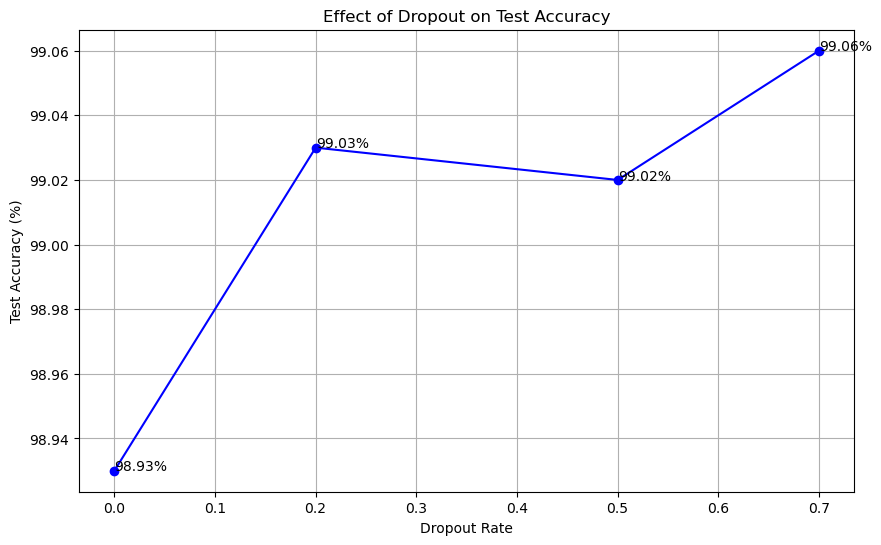

In [31]:
# Plot Accuracy vs Dropout

dropout_list = list(results.keys())
accuracy_list = [float(a) for a in results.values()]

plt.figure(figsize=(10,6))
plt.plot(dropout_list, accuracy_list, marker='o', color='blue')
for rate, acc in zip(dropout_list, accuracy_list):
    plt.text(rate, acc, f"{acc:.2f}%", ha='left')
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy (%)")
plt.title("Effect of Dropout on Test Accuracy")
plt.grid(True)
plt.show()

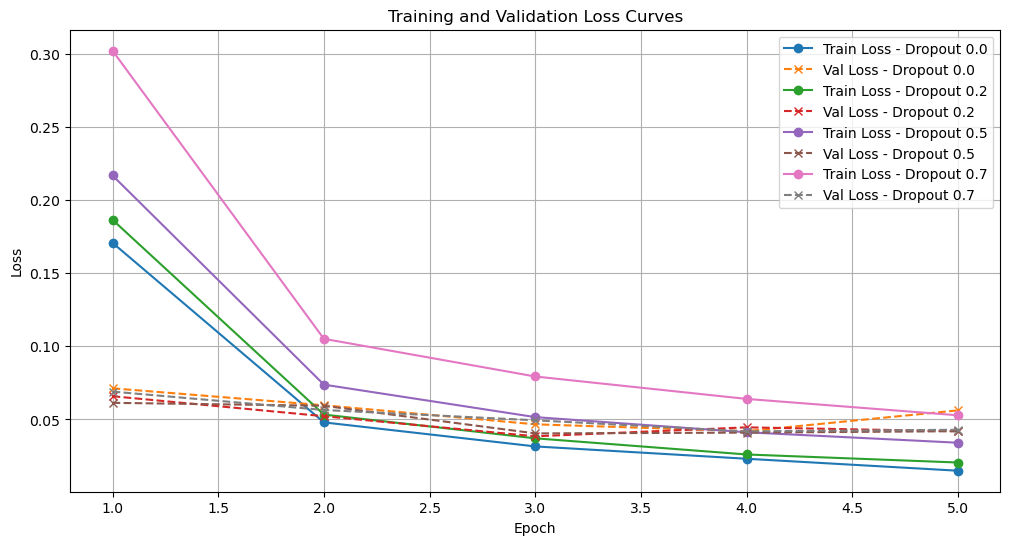

In [32]:
# Plot Training & Validation Loss Curves

plt.figure(figsize=(12,6))
for rate in dropout_rates:
    plt.plot(range(1, len(all_train_losses[rate])+1), all_train_losses[rate], marker='o', label=f'Train Loss - Dropout {rate}')
    plt.plot(range(1, len(all_val_losses[rate])+1), all_val_losses[rate], marker='x', linestyle='--', label=f'Val Loss - Dropout {rate}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Display Runtimes

print("\nRuntime per Dropout Rate:")
for rate, rt in runtimes.items():
    print(f"Dropout {rate}: {rt:.2f} seconds")


Runtime per Dropout Rate:
Dropout 0.0: 629.55 seconds
Dropout 0.2: 661.27 seconds
Dropout 0.5: 645.39 seconds
Dropout 0.7: 684.78 seconds
